# 深度學習Pytorch手把手實作-資料庫: Data loader example by pytorch 

### 此部分我們先介紹
<br>**<font color = blue size=4 face=雅黑>I. 當dataset是torch vision提供的寫法</font>**<br/>  
<br>**<font color = blue size=4 face=雅黑>II. 當dataset是私有資料庫的寫法。</font>**<br/>  
<br>**<font color = blue size=4 face=雅黑>III. 如何將資料丟到CUDA</font>**<br/>  

--------------------

**<font color = blue size=6 >I. 當dataset是torch vision提供的寫法。</font>**
#### Dataset loading方式見 01_database_pytorch.ipynb
Dataset loading是利用torch內建的函數(torch.utils.data.DataLoader)將資料庫放到pytorch的data loader內。

In [1]:
import torch
from torchvision import datasets
dataset_MNIST = datasets.MNIST('./dataset', train=True, download=False)
# 利用torch內建的函數將資料庫放到pytorch的data loader內。
mnistdata_loader = torch.utils.data.DataLoader(dataset_MNIST)

然後我們看一下這個函數定義完後得結果。

In [2]:
type(mnistdata_loader)

torch.utils.data.dataloader.DataLoader

### 我們要怎麼繼續使用這個torch dataloader來進行學習?
>直接用for loop指派即可。

In [3]:
for data, target in mnistdata_loader:
    print(data)
    print(target)
    break

TypeError: default_collate: batch must contain tensors, numpy arrays, numbers, dicts or lists; found <class 'PIL.Image.Image'>

<br>**<font color = red size=4 >咦~~~~~ 上面程式怎麼掛了</font>**<br/>  

<font color = black size=3 >我們看一下錯誤訊息</font>


<font color = red size=3 >「TypeError: default_collate: batch must contain tensors, numpy arrays, numbers, dicts or lists; found <class 'PIL.Image.Image'>」</font>

看起來就是資料格式出錯了，我們輸出的資料是PIL image格式。<br>

<br> **<font color = black size=4 > 要讓torch.utils.data.dataloader.DataLoader運作的方式dataset輸出的資料必須是 tensors, numpy arrays, numbers, dicts or lists</font>**<br/> 

所以我們check看看dataset_MNIST的輸出是什麼？

In [4]:
print(type(dataset_MNIST.data[0,:,:]))
dataset_MNIST.__getitem__(0)

<class 'torch.Tensor'>


(<PIL.Image.Image image mode=L size=28x28 at 0x2B6FC124708>, 5)

雖然 dataset_MNIST.data 可以看到所有的data，而且是torch.Tensor的格式

>**實際上torch的dataloader是看dataset結構內的.__getitem__的輸出 (自定義資料庫的時候會介紹怎麼撰寫)**

所以 dataset_MNIST讀取到的資料其實是**PIL.Image.Image**。


<br> **<font color = red size=3>Question:</font>** 這時候我們要怎麼改讓資料可以順利執行?<br/>
<br> **<font color = red size=3>ANS:</font>**  格式不對就改格式就好了<br/>
 
 trochvision內提供了function，只需要搭配torchvision.transforms的ToTensor()即可。

In [5]:
from torchvision import transforms
transform = transforms.ToTensor()
dataset_MNIST_tensor = datasets.MNIST('./dataset', train=True, download=False, transform=transform)
mnistdata_loader = torch.utils.data.DataLoader(dataset_MNIST_tensor, batch_size=2)

**所以當格式經由torch vision提供的transforms.ToTensor()，可以將資料成功轉換成 torch.tensor，這時候就可以順利跑資料的forloop了。**
>這邊稍微注意一下，我們batch_size設定為2，所以出來的資料會有兩筆，我們在print size時候可以看到

In [6]:
count = 0
for data, target in mnistdata_loader: 
    count+=1
print("total iterations: {}".format(count))
print(data.size())  # batch * channel * h * w
print(target.size()) # batch
print(data)
print(target)

total iterations: 30000
torch.Size([2, 1, 28, 28])
torch.Size([2])
tensor([[[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]],


        [[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]]])
tensor([6, 8])


**因為batch size設定是2，MNIST資料有60000筆資料，這樣一個iteration跑2張圖，所以要跑30000次才能將整個資料集都跑完(一個epoch)，因此整個for loop需要執行30000次。**<br>
我們測試將batch size設定是200，這樣iteration次數應該是60000/200=300次。

In [7]:
mnistdata_loader = torch.utils.data.DataLoader(dataset_MNIST_tensor, batch_size=200, shuffle=True)
count = 0
for data, target in mnistdata_loader:
    count+=1
print("total iterations: {}".format(count))

total iterations: 300



**<font color = green size=5> Shuffle的設定</font>** <br>
**<font color = black size=3> 當 Shuffle = False</font>**<br>
見下面結果，可以發現兩個for loop得到的batch資料結果是**<font color = red >一樣的</font>**。<br>


In [8]:
mnistdata_loader = torch.utils.data.DataLoader(dataset_MNIST_tensor, batch_size=2, shuffle=False)
print("first epoch")
for data, target in mnistdata_loader:
    print(target)
    break
print("Second epoch")
for data, target in mnistdata_loader:
    print(target)
    break

first epoch
tensor([5, 0])
Second epoch
tensor([5, 0])


**<font color = black size=3> 當 Shuffle = True</font>**<br>
見下面結果，可以發現兩個for loop第一次得到的資料結果是 **<font color = red >不一樣的</font>**。<br>

In [9]:
mnistdata_loader = torch.utils.data.DataLoader(dataset_MNIST_tensor, batch_size=2, shuffle=True)
print("first epoch")
for data, target in mnistdata_loader:
    print(target)
    break
print("Second epoch")
for data, target in mnistdata_loader:
    print(target)
    break

first epoch
tensor([5, 1])
Second epoch
tensor([9, 7])


>**要避免每一個epoch都學習一樣的順序和一樣的batch時候Shuffle就需要設定為True** <br>

這樣資料在每一次for loop(每個epoch)的時候，每個batch的組合都會重新打亂，這樣learning model過程中可以避免每個epoch學習都是在學習固定的pattern。




---------------------
**<font color = green size=5> num_worker的設定</font>** <br>
num_worker: 用來進行平行運算的CPU數量。每個數量會去處理不同的batch data。

運作模式: <br>
假設我們的資料有三個batch，batch 1, batch 2, batch 3。<br>
當num_worker=0，CPU會batch 1處理好在繼續處理batch 2，batch 2處理好在繼續處理batch 3。 (**下圖上**)<br>
當num_worker=3，CPU會開三條平行運算的線，第一條處理batch 1，第二條處理batch 2，第三條處理batch 3(**下圖下**)。<br>
<img src="Image/parallel.png"  width="40%">

下面我們測試不同num_workers會有什麼差異。

batch_size:2
batch_size:10
batch_size:100


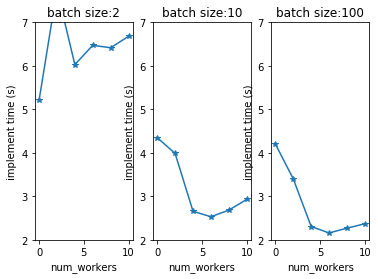

In [11]:
from torchvision import transforms
import time
import numpy as np
import matplotlib.pyplot as plt
dataset_MNIST_tensor = datasets.MNIST('./dataset', train=True, download=False, transform= transforms.ToTensor())
def fun_timetest(data_loader):
    start = time.time()
    count=0
    for data, target in data_loader:
        count+=1
    timeimplement = time.time()-start
#     print("total iteration: {}, a forloop time for whole dataset within CPU: {}s".format(count, timeimplement) )
    return timeimplement

###
if __name__ == "__main__":
    for i_subplot, batch_size in enumerate([2,10,100]):
        record = []
        print("batch_size:{}".format(batch_size))
        for i in range(0,12,2):
            mnistdata_loader = torch.utils.data.DataLoader(dataset_MNIST_tensor, batch_size=batch_size, shuffle=True, num_workers=i)
    #         print("num_workers: {}".format(i))
            timeimplement= fun_timetest(mnistdata_loader)
            record.append([i,timeimplement])
        record = np.array(record)
        plt.subplot(1,3,i_subplot+1)
        plt.plot(record[:,0],record[:,1],'*-')
        plt.ylim([2,7])
        plt.xlabel('num_workers')
        plt.ylabel('implement time (s)')
        plt.title('batch size:{}'.format(batch_size))

>num_workers 這個數字不是越高越好，一般建議設定為4~6。

---------------------
**<font color = blue size=6 >II. 當dataset是私有資料庫的寫法</font>**

我們剛剛介紹了，pytorch的dataloder使用方式，基本上自有的資料庫在dataloader用法完全一樣。

**<font color = black size=4>唯一不同的部分在於dataset的宣告。</font>**


""""""""""""""""""""""""""""""""<br>
**<font color = green size=4>dataset_MNIST_tensor = datasets.MNIST('./dataset', train=True, download=False, transform=transform)</font>**

""""""""""""""""""""""""""""""""<br>

<font color = black size=4> 此部分就是要介紹如何在pytorch自定義dataset，也就是「**dataset_MNIST_tensor = datasets.MNIST('./dataset')**」這行怎麼出來的</font><br>

<font color = black size=4>**這邊我們用前面私有資料庫介紹的Car Brands Images來說明。**</font><br>


In [1]:
import torch
import numpy as np
import PIL.Image as Image
import torchvision.transforms.functional as FT
from torchvision import transforms

import json
__author__ = "Chih-Sheng(Tommy) Huang"

mytransform=transforms.Compose([
        transforms.Resize((224,224)),
        transforms.ToTensor(),
        ])

class MyDataset_CarBrandsImages(torch.utils.data.Dataset):
    '''
    Class to load the dataset
    '''
    def __init__(self,transforms):
        
        with open('./dataset/kaggle/CarBrandsImages/carbrand.json') as jsonfile:
            data_load = json.load(jsonfile)
        self.imList = data_load['imagepaths']
        self.labelList = data_load['labels']
        self.transforms=transforms
        print('number of total data:{}'.format(len(self.imList)))
    def __len__(self):
        return len(self.imList)

    def __getitem__(self, idx):
        '''
        :param idx: Index of the image file
        :return: returns the image and corresponding label file.
        '''
        image_name = self.imList[idx]
        label = self.labelList[idx]
        
        # read image with PIL module
        image = Image.open(image_name, mode='r')
        image = image.convert('RGB')
        
        # Convert PIL label image to torch.Tensor
        image = self.transforms(image)
        label = torch.tensor(label)
        return image, label

if __name__ == "__main__":
    mydataset = MyDataset_CarBrandsImages(transforms=mytransform)
    mydata_loader = torch.utils.data.DataLoader(mydataset, batch_size=10, num_workers=0)
    for data, target in mydata_loader:
        print(data.size())
        print(target.size())
        break    


number of total data:4597
torch.Size([10, 3, 224, 224])
torch.Size([10])


**<font color = blue size=4> workers在私有資料集測試 </font>**<br>

>**<font color = red size=3>Windows系統不能處理num_workers>0</font>**<br>

**我們這邊試著將worker打開做平行處理**<br>
**worker打開後會發生其他問題**

In [9]:
if __name__ == '__main__':
    mydataset = MyDataset_CarBrandsImages(transforms=mytransform)
    mydata_loader = torch.utils.data.DataLoader(mydataset, batch_size=100, num_workers=3)
    for data, target in mydata_loader:
        print(data.size())
        print(target.size())
         

number of total data:4597


BrokenPipeError: [Errno 32] Broken pipe

在Linux執行還是會發生下面這個error<br>
**「RuntimeError: invalid argument 0: Sizes of tensors must match except in dimension 0. Got 1 and 0 in dimension 1 at C:\w\1\s\tmp_conda_3.7_100118\conda\conda-bld\pytorch_1579082551706\work\aten\src\TH/generic/THTensor.cpp:612」**
reference: https://discuss.pytorch.org/t/runtimeerror-invalid-argument-0-sizes-of-tensors-must-match-except-in-dimension-0-pls-help/40852

**<font color = red size=3> 原因在於 整個database資料數和batch size的關係</font>**<br>
>**<font color = black size=3>整個database有4597筆資料，batch size不論是設為2或是10都是除不盡的，也就是最後一個iteration資料的shape會和前面的都不一樣，這個時候系統就會報錯誤。<br>
解決方法: 在dataset的class宣告要多加一個collate_fn。**</font>

然後我們要定義一個collate_fn用的function，可以一起定義在mydataset裡面，也可以額外定義function，通常是建議在mydataset定義會比較好。

In [7]:
def my_collate(batch):
    data, target = list(), list()
    for b in batch:
        data.append(b[0])
        target.append(b[1])
    data = torch.stack(data,dim=0)
    target = torch.stack(target,dim=0)
    return data, target
mydataset = MyDataset_CarBrandsImages(transforms=mytransform)
mydata_loader = torch.utils.data.DataLoader(mydataset, batch_size=100, num_workers=0, collate_fn = my_collate)
for data, target in mydata_loader:
    print(target.size())

number of total data:4597
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([97])


 **這邊我們測試看看如果需要讀圖檔下，開不開workers差多少，請看另一份檔案，或是在Linux下執行**

In [ ]:
import time
import numpy as np
import matplotlib.pyplot as plt

mydataset = MyDataset_CarBrandsImages(transforms=mytransform)

def fun_timetest(data_loader):
    start = time.time()
    count=0
    for data, target in data_loader:
        count+=1
    timeimplement = time.time()-start
    print("total iteration: {}, a forloop time for whole dataset within CPU: {}s".format(count, timeimplement) )
    return timeimplement

for i in [0, 2, 4, 8]:
    mydata_loader = torch.utils.data.DataLoader(mydataset, batch_size=24, num_workers=i)
    print("\n num_workers: {}".format(i))
    timeimplement = fun_timetest(mydata_loader)



--------------------
**<font color = blue size=6 >III. 如何將資料丟到CUDA。</font>**


在torch的tensor下直接.to(device)即可，但device需要先宣告。

In [4]:
from torchvision import datasets, transforms
import torch
transform = transforms.ToTensor()
dataset_MNIST_tensor = datasets.MNIST('./dataset', train=True, download=False, transform=transform)
mnistdata_loader = torch.utils.data.DataLoader(dataset_MNIST_tensor, batch_size=2)


use_cuda = 1
device = torch.device("cuda:0" if use_cuda else "cpu")
print(device)
for data, target in mnistdata_loader:
    print(target)
    data, target = data.to(device), target.to(device)
    print(target)
    break

cuda:0
tensor([5, 0])
tensor([5, 0], device='cuda:0')


## 我們針對CPU mode的tensor和CUDA mode的tensor做操作看看

### 1. CPU Tensor 相加

In [5]:
use_cuda = 1
device = torch.device("cuda" if use_cuda else "cpu")
one = torch.Tensor([1])
for data, target in mnistdata_loader:
    print(data+one)
    break

tensor([[[[1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          ...,
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.]]],


        [[[1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          ...,
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.]]]])


### 2. CUDA Tensor 加 CPU Tensor

In [6]:
for data, target in mnistdata_loader:
    data, target = data.to(device), target.to(device)
    print(data+one)
    break

RuntimeError: expected device cuda:0 but got device cpu

### 3. CUDA Tensor 加 CUDA Tensor

In [7]:
one = torch.Tensor([1])
one = one.to(device)
for data, target in mnistdata_loader:
    data, target = data.to(device), target.to(device)
    print(target+one)
    break

tensor([6., 1.], device='cuda:0')


### 4. 測試CPU和CUDA之間資料搬移

In [8]:
import time
def test_time(data_loader):
    start = time.time()
    count=0
    for data, target in data_loader:
        count+=1
    print("a forloop time for whole dataset within CPU: {}s".format(time.time()-start))

    start = time.time()
    count=0
    for data, target in data_loader:
        data, target = data.to(device), target.to(device)
        count+=1
    print("a forloop time for whole dataset with CPU to CUDA: {}s".format(time.time()-start))
    
print("When batch size = 10")
mnistdata_loader = torch.utils.data.DataLoader(dataset_MNIST_tensor, batch_size=10, shuffle=False)
test_time(mnistdata_loader)

print("\nWhen batch size = 2")
mnistdata_loader = torch.utils.data.DataLoader(dataset_MNIST_tensor, batch_size=2, shuffle=False)
test_time(mnistdata_loader)


When batch size = 10
a forloop time for whole dataset within CPU: 4.247750759124756s
a forloop time for whole dataset with CPU to CUDA: 5.4835333824157715s

When batch size = 2
a forloop time for whole dataset within CPU: 4.938941717147827s
a forloop time for whole dataset with CPU to CUDA: 8.394227981567383s


</font>**<font color = black size=4 >Note: </font>**<br>

**<font color = black size=3 >1:資料跑來跑去一定花費data bandwidth，導致時間會變慢，所以在pytorch撰寫過程中要盡量避免資料在CPU和GPU之間跑來跑去。</font>**<br>

**<font color = black size=3 >2: 容易造成CPU的tensor和CUDA的tensor進行運算的error，在進行運算要注意是在CPU還是CUDA。</font>**
